In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.cm as cm
import random
import glob
import os

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [11]:
def check_dataset(dataset):
   plt.figure(figsize=(10, 10))
   for images, labels in dataset.take(1):
      for i in range(9):
         ax = plt.subplot(3, 3, i + 1)
         plt.imshow(images[i].numpy().astype("uint8"))
         plt.title('...' + train_ds.file_paths[i][-20:])
         plt.axis("off")

root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

root_modeldir = os.path.join(os.curdir, "my_models")
def get_model_dir():
   import time
   run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
   return os.path.join(root_modeldir, run_id)

def find_target_layer(model):
   # attempt to find the final convolutional layer in the network
   # by looping over the layers of the network in reverse order
   for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4:
         return layer.name
   # otherwise, we could not find a 4D layer so the GradCAM
   # algorithm cannot be applied
   raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array
   
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def build_gradcam(img_path, heatmap, color_map, original_image_colormap, alpha=0.5):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path, color_mode=original_image_colormap)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    # jet = cm.get_cmap("jet")
    jet = cm.get_cmap(color_map)
    # jet = cm.get_cmap("OrRd")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # # Save the superimposed image
    # superimposed_img.save(cam_path)

    # # Display Grad CAM
    # display(Image(cam_path))

    # Return image
    return superimposed_img

def superimpose_gradcam(img_path, image_size, current_model, grad_colormap, original_image_colormap, last_layer_grad_cam):
   preprocess_input = keras.applications.xception.preprocess_input
   # img_path = "PetImages\\Cat\\1157.jpg"
   # Prepare image
   img_array = preprocess_input(get_img_array(img_path, size=image_size))

   # Remove last layer's softmax
   current_model.layers[-1].activation = None

   # Generate class activation heatmap
   last_conv_layer_name = find_target_layer(current_model)
   heatmap = make_gradcam_heatmap(img_array, current_model, last_conv_layer_name=last_layer_grad_cam)
   return build_gradcam(img_path, heatmap, color_map=grad_colormap, original_image_colormap=original_image_colormap)

def test_grad_cam_in_path(current_model, default_images_path, image_size, grad_colormap, original_image_colormap, last_layer_grad_cam):
   plt.figure(figsize=(10, 10))
   list_images = glob.glob(default_images_path + "*")
   for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      img_path = random.choice(list_images)
      superimposed_img = superimpose_gradcam( 
                        current_model=current_model, 
                        img_path=img_path,
                        image_size=image_size,
                        grad_colormap=grad_colormap,
                        original_image_colormap=original_image_colormap,
                        last_layer_grad_cam=last_layer_grad_cam)
      plt.imshow(superimposed_img)
      plt.title('{}'.format(img_path[-20:]))
      plt.axis("off")

In [9]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

In [5]:
data_dir = 'datasetsSARS-COV-2 Ct-Scan'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="training",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2481 files belonging to 2 classes.
Using 1985 files for training.
Found 2481 files belonging to 2 classes.
Using 496 files for validation.


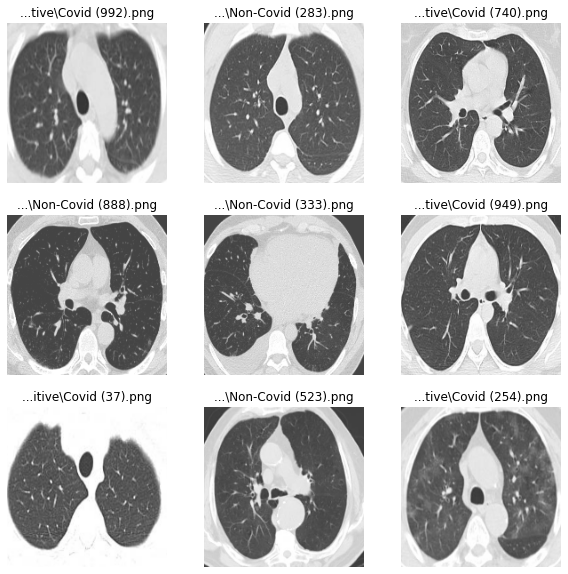

In [6]:
check_dataset(train_ds)

In [7]:
def find_target_layer_2(model):
   # attempt to find the final convolutional layer in the network
   # by looping over the layers of the network in reverse order
   for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      # if len(layer.output_shape) == 4:
      return layer
   # otherwise, we could not find a 4D layer so the GradCAM
   # algorithm cannot be applied
   # raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


In [32]:
inputs = keras.Input(shape=(img_height, img_width, 3))

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)
x = scale_layer(x)
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
base_model = keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
    input_tensor=x
)
last_layer_base_model = find_target_layer_2(base_model)
# x = keras.layers.Conv2D(
#     filters=512, 
#     # name='last_conv_layer', 
#     kernel_size=2, 
#     strides=1, 
#     activation='relu', 
#     padding="SAME")(last_layer_base_model.output)

# x = keras.layers.Conv2D(
#     filters=512, 
#     # name='last_conv_layer', 
#     kernel_size=2, 
#     strides=1, 
#     activation='relu', 
#     padding="SAME")(x)

# x = keras.layers.MaxPool2D()()

x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_base_model.output)

x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=32, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

base_model.trainable = False # Freeze base model

model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 180, 180, 3)  0           input_17[0][0]                   
__________________________________________________________________________________________________
rescaling_16 (Rescaling)        (None, 180, 180, 3)  0           sequential_16[0][0]              
__________________________________________________________________________________________________
conv2d_3257 (Conv2D)            (None, 89, 89, 32)   864         rescaling_16[0][0]               
___________________________________________________________________________________________

In [9]:
find_target_layer(model)

'dense_2'

In [22]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

KeyboardInterrupt: 

In [33]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

epochs = 100
base_model.trainable = False
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[tensorboard_cb, early_stopping_cb])

Epoch 1/100
63/63 [==============================] - 24s 224ms/step - loss: 0.8236 - accuracy: 0.5209 - val_loss: 0.6622 - val_accuracy: 0.6391
Epoch 2/100
63/63 [==============================] - 9s 145ms/step - loss: 0.6615 - accuracy: 0.5859 - val_loss: 0.6059 - val_accuracy: 0.7137
Epoch 3/100
63/63 [==============================] - 9s 145ms/step - loss: 0.6426 - accuracy: 0.6388 - val_loss: 0.5799 - val_accuracy: 0.7117
Epoch 4/100
63/63 [==============================] - 9s 150ms/step - loss: 0.6227 - accuracy: 0.6746 - val_loss: 0.5686 - val_accuracy: 0.7278
Epoch 5/100
63/63 [==============================] - 9s 139ms/step - loss: 0.6108 - accuracy: 0.6594 - val_loss: 0.5493 - val_accuracy: 0.7339
Epoch 6/100
63/63 [==============================] - 9s 141ms/step - loss: 0.6029 - accuracy: 0.6831 - val_loss: 0.5737 - val_accuracy: 0.6815
Epoch 7/100
63/63 [==============================] - 10s 151ms/step - loss: 0.6103 - accuracy: 0.6766 - val_loss: 0.5256 - val_accuracy: 0.77

Testando predições do modelo

In [34]:
img_path = "datasetsSARS-COV-2 Ct-Scan\\COVID-positive\\Covid (100).png"
img_array = get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
preds

array([[0.94186854]], dtype=float32)

In [35]:
img_path = "datasetsSARS-COV-2 Ct-Scan\\COVID-negative\\Non-Covid (100).png"
img_array = get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
preds

array([[0.3327028]], dtype=float32)

In [36]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

epochs = 100
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[tensorboard_cb, early_stopping_cb])

run_modeldir = get_model_dir()
model.save(run_modeldir)

Epoch 1/100
63/63 [==============================] - 49s 509ms/step - loss: 0.6448 - accuracy: 0.6514 - val_loss: 0.5141 - val_accuracy: 0.7359
Epoch 2/100
63/63 [==============================] - 26s 410ms/step - loss: 0.5584 - accuracy: 0.7174 - val_loss: 0.5306 - val_accuracy: 0.7056
Epoch 3/100
63/63 [==============================] - 27s 431ms/step - loss: 0.5185 - accuracy: 0.7577 - val_loss: 0.4997 - val_accuracy: 0.7177
Epoch 4/100
63/63 [==============================] - 27s 429ms/step - loss: 0.5036 - accuracy: 0.7652 - val_loss: 0.4800 - val_accuracy: 0.7339
Epoch 5/100
63/63 [==============================] - 27s 428ms/step - loss: 0.4795 - accuracy: 0.7904 - val_loss: 0.4608 - val_accuracy: 0.7823
Epoch 6/100
63/63 [==============================] - 25s 405ms/step - loss: 0.4802 - accuracy: 0.7884 - val_loss: 0.4476 - val_accuracy: 0.7984
Epoch 7/100
63/63 [==============================] - 25s 404ms/step - loss: 0.4650 - accuracy: 0.7940 - val_loss: 0.4215 - val_accuracy:

In [37]:
img_path = "datasetsSARS-COV-2 Ct-Scan\\COVID-positive\\Covid (100).png"
img_array = get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
preds

array([[0.98751485]], dtype=float32)

In [38]:
img_path = "datasetsSARS-COV-2 Ct-Scan\\COVID-negative\\Non-Covid (100).png"
img_array = get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
preds

array([[0.31399584]], dtype=float32)

In [ ]:
def run_transfer_training(train_ds, val_ds, current_model):
   print(">>>FIRST RUN: FREEZING BASE_MODEL<<< \n")
   optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
   current_model.compile(
      optimizer=optimizer,
      loss=keras.losses.BinaryCrossentropy(),
      metrics=["accuracy"])

   early_stopping_cb = keras.callbacks.EarlyStopping(
      patience=5,
      restore_best_weights=True)

   run_logdir = get_run_logdir()
   epochs = 100
   base_model.trainable = False
   tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
   print(model.summary)
   model.fit(
      train_ds, 
      epochs=epochs,
      batch_size=32,
      validation_data=val_ds,
      callbacks=[tensorboard_cb, early_stopping_cb])
   
   print(">>>LAST RUN: UNFREEZING BASE_MODEL<<< \n")
   # Unfreeze the base_model. Note that it keeps running in inference mode
   # since we passed `training=False` when calling it. This means that
   # the batchnorm layers will not update their batch statistics.
   # This prevents the batchnorm layers from undoing all the training
   # we've done so far.
   base_model.trainable = True

   model.compile(
      optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
      loss=keras.losses.BinaryCrossentropy(),
      metrics=["accuracy"])

   epochs = 100
   run_logdir = get_run_logdir()
   tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
   print(model.summary)
   model.fit(
      train_ds, 
      epochs=epochs,
      batch_size=32,
      validation_data=val_ds,
      callbacks=[tensorboard_cb, early_stopping_cb])

   run_modeldir = get_model_dir()
   model.save(run_modeldir)

In [39]:
find_target_layer(model)

'conv_7b_ac'

In [2]:
import keras

In [13]:
model = keras.models.load_model("my_models\\run_2021_10_31-22_35_27")

In [14]:
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 180, 180, 3)  0           input_17[0][0]                   
__________________________________________________________________________________________________
rescaling_16 (Rescaling)        (None, 180, 180, 3)  0           sequential_16[0][0]              
__________________________________________________________________________________________________
conv2d_3257 (Conv2D)            (None, 89, 89, 32)   864         rescaling_16[0][0]               
___________________________________________________________________________________________

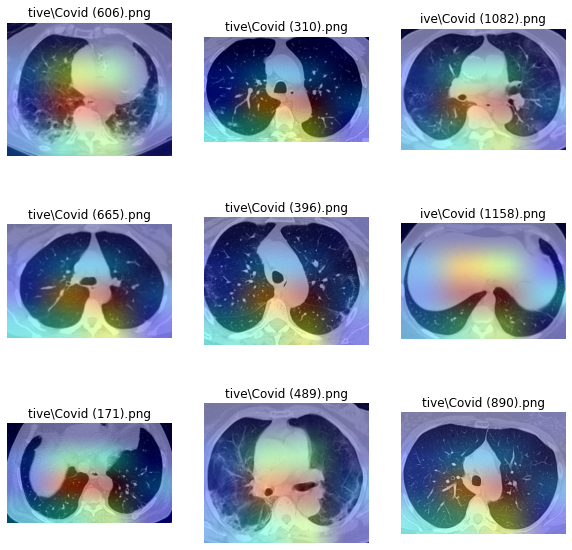

In [22]:
test_grad_cam_in_path(
      model,
      "datasetsSARS-COV-2 Ct-Scan\\COVID-positive\\",
      image_size,
      grad_colormap="jet",
      original_image_colormap="grayscale",
      last_layer_grad_cam='conv_7b_ac')

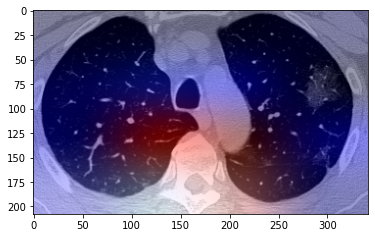

In [24]:
img_path = "datasetsSARS-COV-2 Ct-Scan\\COVID-positive\\Covid (305).png"
superimposed_img = superimpose_gradcam( 
   current_model=model, 
   img_path=img_path,
   image_size=image_size,
   grad_colormap="seismic",
   original_image_colormap="grayscale",
   last_layer_grad_cam='conv_7b_ac')

plt.imshow(superimposed_img)

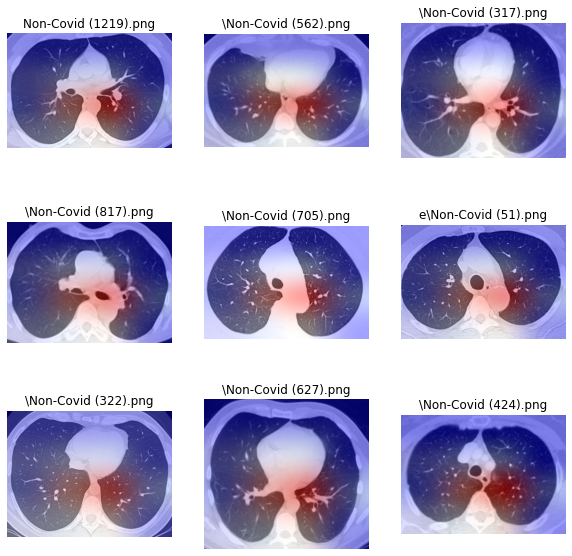

In [23]:
test_grad_cam_in_path(
      model,
      "datasetsSARS-COV-2 Ct-Scan\\COVID-negative\\",
      image_size,
      grad_colormap="bwr",
      original_image_colormap="grayscale",
      last_layer_grad_cam='conv_7b_ac')